# Elaboration of our own database of foods as the set of alternatives



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Access

In [ ]:
import requests
import pandas as pd

# OpenFoodFacts API
API_URL = "https://world.openfoodfacts.org/cgi/search.pl"
PAGE_SIZE = 200

params = {
    'action': 'process',
    'json': 1,
    'fields': 'product_name,nutrition_grades,ecoscore_score,energy_100g,sugars_100g,saturated-fat_100g,salt_100g,proteins_100g,fiber_100g,fruits-vegetables-nuts_100g,categories,countries_tags,code',
    'page_size': PAGE_SIZE,
}

ALLOWED_COUNTRIES = "france"
ALLOWED_CATEGORIES = ['Snacks', 'Biscuits', 'Cereals', 'Meals', 'Beverages', 'Cheeses','Frozen foods','Fruits based']

def fetch_data(page=1):
    """
    Fetch data from OpenFoodFacts API for a given page.
    """
    params['page'] = page
    response = requests.get(API_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        return data.get('products', [])
    else:
        print(f"Error fetching data for page {page}: {response.status_code}")
        return []

def fetch_multiple_pages(total_pages=10):
    """
    Fetch multiple pages of data from the API.
    """
    all_products = []
    for page in range(1, total_pages + 1):
        print(f"Fetching page {page}...")
        products = fetch_data(page)
        if not products:
            print(f"No data found on page {page}. Stopping fetch.")
            break
        all_products.extend(products)
    print(f"Fetched {len(all_products)} products in total.")
    return all_products

def clean_and_format_data(products):
    """
    Clean and format the raw product data into a structured format.
    """
    formatted_data = []
    for product in products:
        food_name = product.get('product_name', 'Unknown')
        nutri_score = product.get('nutrition_grades', 'Unknown')
        ecoscore = product.get('ecoscore_score', 'Unknown')
        energy_kj = product.get('energy_100g', 0)  # Energy (KJ)
        sugars = product.get('sugars_100g', 0)  # Sugars (g)
        saturated_fat = product.get('saturated-fat_100g', 0)  # Saturated fatty acids (g)
        salt = product.get('salt_100g', 0)  # Salt (g)
        proteins = product.get('proteins_100g', 0)  # Proteins (g)
        fiber = product.get('fiber_100g', 0)  # Fiber (g)
        fruit_veg_percentage = product.get('fruits-vegetables-nuts_100g', 0)  # Fruit/Vegetable (%)
        categories = product.get('categories', 'Unknown')  # Categories
        countries = ", ".join(product.get('countries_tags', []))  # Countries
        barcode = product.get('code', 'Unknown')  # Barcode

        # Filter by country and categories
        if ALLOWED_COUNTRIES not in countries.lower():
            continue
        if not any(category.lower() in categories.lower() for category in ALLOWED_CATEGORIES):
            continue

        # Validate Nutri-Score and Ecoscore
        if nutri_score not in ['a', 'b', 'c', 'd', 'e']:
            continue
        try:
            ecoscore = float(ecoscore)
        except ValueError:
            continue

        formatted_data.append({
            'Food Name': food_name,
            'Energy (KJ/100g)': energy_kj,
            'Sugars (g/100g)': sugars,
            'Saturated Fat (g/100g)': saturated_fat,
            'Salt (g/100g)': salt,
            'Proteins (g/100g)': proteins,
            'Fiber (g/100g)': fiber,
            'Fruit/Veg (%)': fruit_veg_percentage,
            'Categories': categories,
            'Countries': countries,
            'Barcode': barcode,
            'Nutri-Score': nutri_score,
            'Ecoscore': ecoscore
        })

    # Remove duplicates based on food name
    df = pd.DataFrame(formatted_data)
    formatted_data = df.drop_duplicates(subset=['Food Name']).to_dict('records')
    print(f"Cleaned and formatted data. Total unique products: {len(formatted_data)}")
    return formatted_data

def save_to_excel(data, filename="/content/drive/MyDrive/Colab Notebooks/DM_Sacaly/food_data_filtered1.xlsx"):
    """
    Save the formatted data to an Excel file.
    """
    if not data:
        print("No data to save.")
        return
    df = pd.DataFrame(data)
    df.to_excel(filename, index=False)
    print(f"Data saved to {filename}")

def main(total_pages=20, filename="/content/drive/MyDrive/Colab Notebooks/DM_Sacaly/food_data_filtered1.xlsx"):
    """
    Main function to fetch, process, and save data.
    """
    print("Starting data fetching process...")
    products = fetch_multiple_pages(total_pages=total_pages)

    if not products:
        print("No products fetched. Exiting.")
        return

    formatted_data = clean_and_format_data(products)
    save_to_excel(formatted_data, filename=filename)

if __name__ == "__main__":
    # Change the number of pages as needed
    main(total_pages=20)


Mounted at /content/drive
Starting data fetching process...
Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...
Fetching page 11...
Error fetching data for page 11: 429
No data found on page 11. Stopping fetch.
Fetched 1000 products in total.
Cleaned and formatted data. Total unique products: 303
Data saved to /content/drive/MyDrive/Colab Notebooks/DM_Sacaly/food_data_filtered1.xlsx


## Data Cleaning

In [ ]:
import pandas as pd

def clean_data(input_file, output_file):
    """
    Clean the data by removing rows with missing 'Food Name' and duplicate records.

    Parameters:
    - input_file: str, path to the input Excel file.
    - output_file: str, path to save the cleaned data.
    """
    try:
        # Load data
        print(f"Loading data from {input_file}...")
        df = pd.read_excel(input_file)
        print(f"Original data loaded with {len(df)} rows.")

        # Drop rows where 'Food Name' is missing
        df_cleaned = df.dropna(subset=['Food Name'])
        print(f"Rows with missing 'Food Name' removed: {len(df) - len(df_cleaned)}")

        # Drop duplicate 'Food Name' entries, keeping the first occurrence
        df_cleaned = df_cleaned.drop_duplicates(subset=['Food Name'], keep='first')
        print(f"Duplicate 'Food Name' entries removed: {len(df) - len(df_cleaned)}")

        # Save cleaned data to output file
        df_cleaned.to_excel(output_file, index=False)
        print(f"Data has been cleaned and saved to {output_file}")
        print(f"Cleaned data contains {len(df_cleaned)} rows.")

    except FileNotFoundError:
        print(f"Error: The file {input_file} does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Main execution
if __name__ == "__main__":
    # Define input and output file paths for Google Colab
    input_file = "/content/drive/MyDrive/Colab Notebooks/DM_Sacaly/food_data_filtered1.xlsx"
    output_file = "/content/drive/MyDrive/Colab Notebooks/DM_Sacaly/food_data_cleaned1.xlsx"

    # Call the clean_data function
    clean_data(input_file, output_file)


Loading data from /content/drive/MyDrive/Colab Notebooks/DM_Sacaly/food_data_filtered1.xlsx...
Original data loaded with 303 rows.
Rows with missing 'Food Name' removed: 1
Duplicate 'Food Name' entries removed: 1
Data has been cleaned and saved to /content/drive/MyDrive/Colab Notebooks/DM_Sacaly/food_data_cleaned1.xlsx
Cleaned data contains 302 rows.


## Comparison with other group's database(Ben,Qasim,Gabriel).

In [ ]:
import pandas as pd

# File paths
file1 = "/content/drive/MyDrive/Colab Notebooks/DM_Sacaly/food_data_cleaned1.xlsx"
file2 = "/content/drive/MyDrive/Colab Notebooks/DM_Sacaly/products.xlsx"

# Load the files
data1 = pd.read_excel(file1)
data2 = pd.read_excel(file2)

# Ensure 'Barcode' in file1 and 'barcode' in file2 exist
if 'Barcode' in data1.columns and 'barcode' in data2.columns:
    # Extract barcodes
    barcodes1 = set(data1['Barcode'].dropna().unique())
    barcodes2 = set(data2['barcode'].dropna().unique())

    # Calculate overlap
    overlap = barcodes1.intersection(barcodes2)
    overlap_percentage = (len(overlap) / min(len(barcodes1), len(barcodes2))) * 100

    # Print results
    print(f"Total barcodes in File 1: {len(barcodes1)}")
    print(f"Total barcodes in File 2: {len(barcodes2)}")
    print(f"Number of overlapping barcodes: {len(overlap)}")
    print(f"Overlap percentage: {overlap_percentage:.2f}%")

    # Check if overlap is less than 30%
    if overlap_percentage < 30:
        print("Satisfy less than 30% requirement")
    else:
        print("Does not satisfy less than 30% requirement")
else:
    print("Error: 'Barcode' column in file1 or 'barcode' column in file2 is missing.")


Total barcodes in File 1: 302
Total barcodes in File 2: 414
Number of overlapping barcodes: 38
Overlap percentage: 12.58%
Satisfy less than 30% requirement


## Exploratory Data Analysis（EDA）

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/DM_Sacaly/food_data_cleaned1.xlsx"
data = pd.read_excel(file_path)

# Confirm successful data loading
print("Dataset loaded successfully. First 5 rows:")
print(data.head())

# Check numeric columns
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns


Dataset loaded successfully. First 5 rows:
                                     Food Name  Energy (KJ/100g)  \
0                                       Sésame            1961.0   
1                    Lindt Excellence 90% 100g            2590.0   
2  Excellence 85% Cacao Chocolat Noir Puissant            2418.0   
3                                      Cashews            2510.0   
4                                 Tuc Original            2021.0   

   Sugars (g/100g)  Saturated Fat (g/100g)  Salt (g/100g)  Proteins (g/100g)  \
0             17.0                     2.0           0.38               10.0   
1              7.0                    30.0           0.03               10.0   
2             15.0                    27.0           0.02               12.5   
3              6.5                     9.0           0.02               20.5   
4              7.1                     9.0           1.70                8.3   

   Fiber (g/100g)  Fruit/Veg (%)  \
0             4.6              

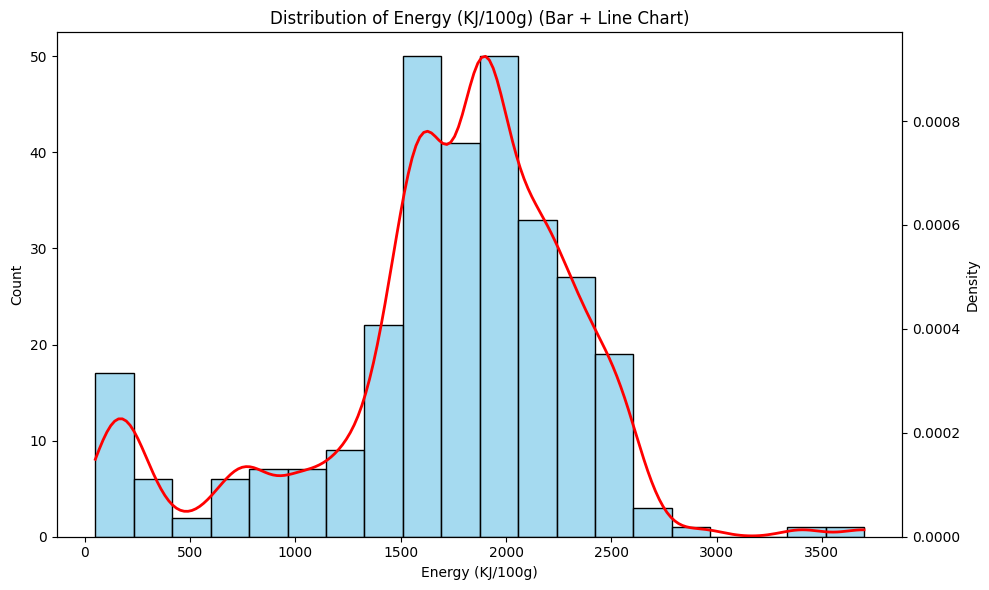

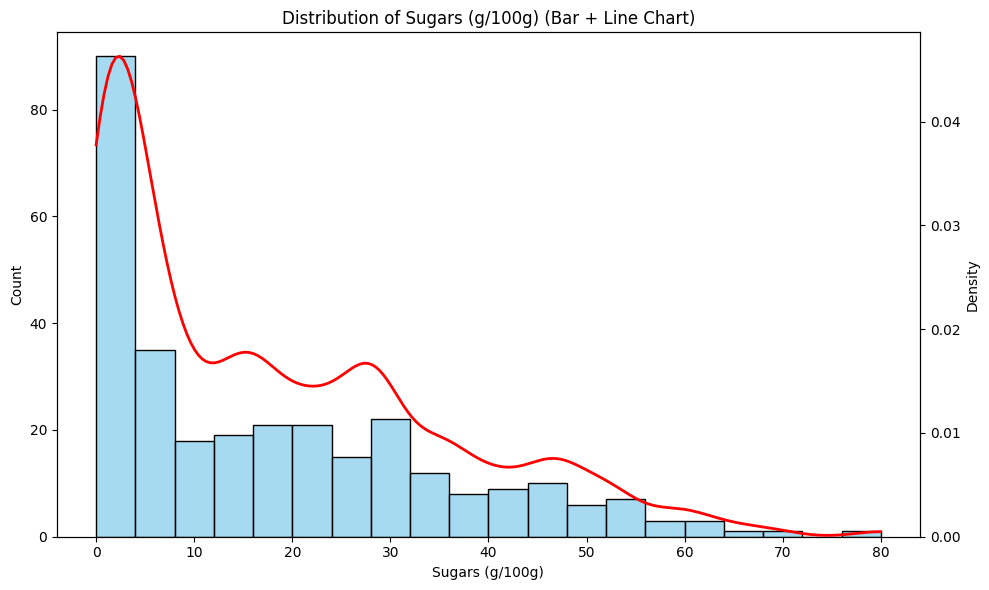

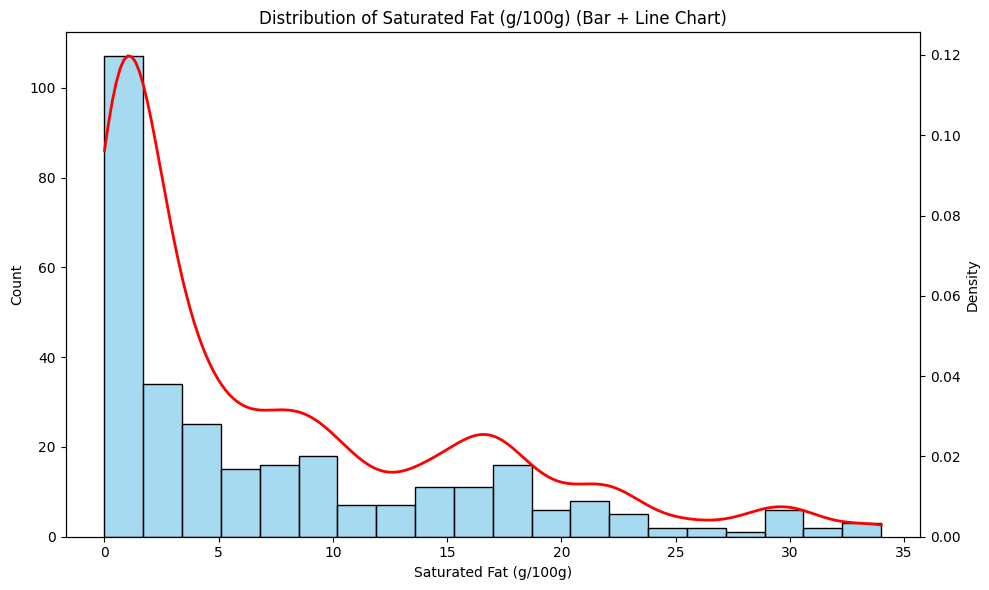

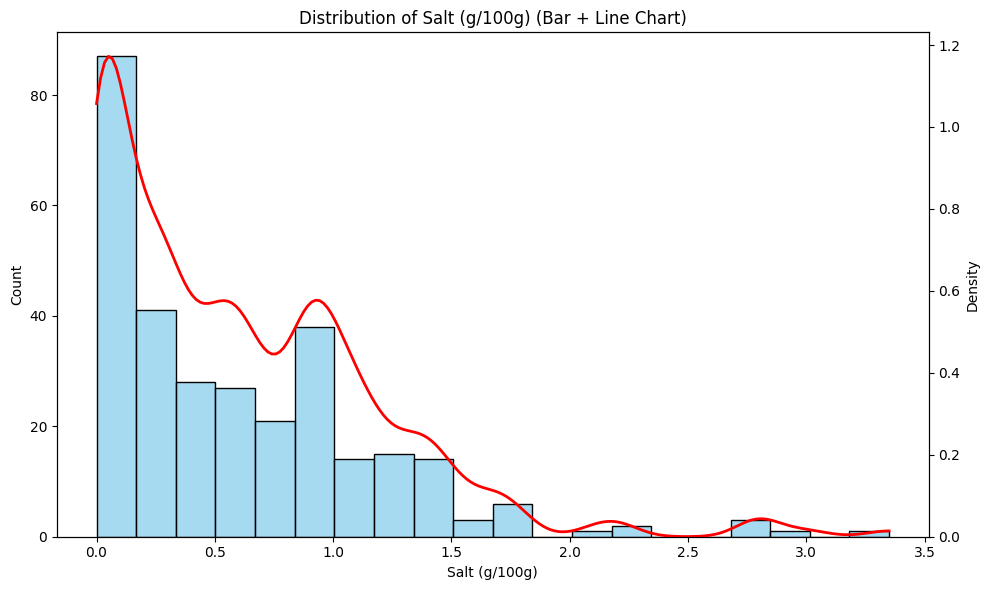

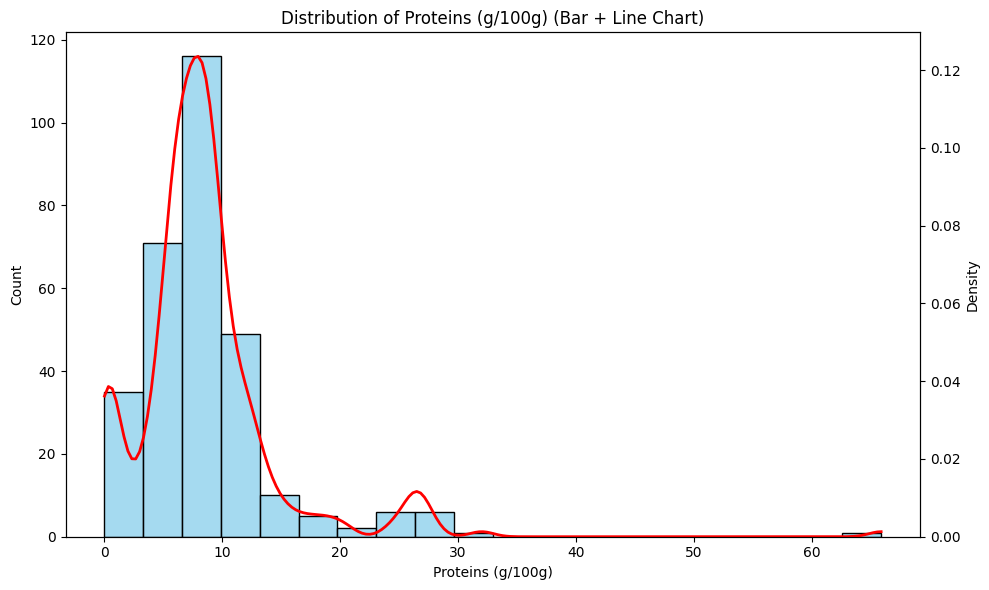

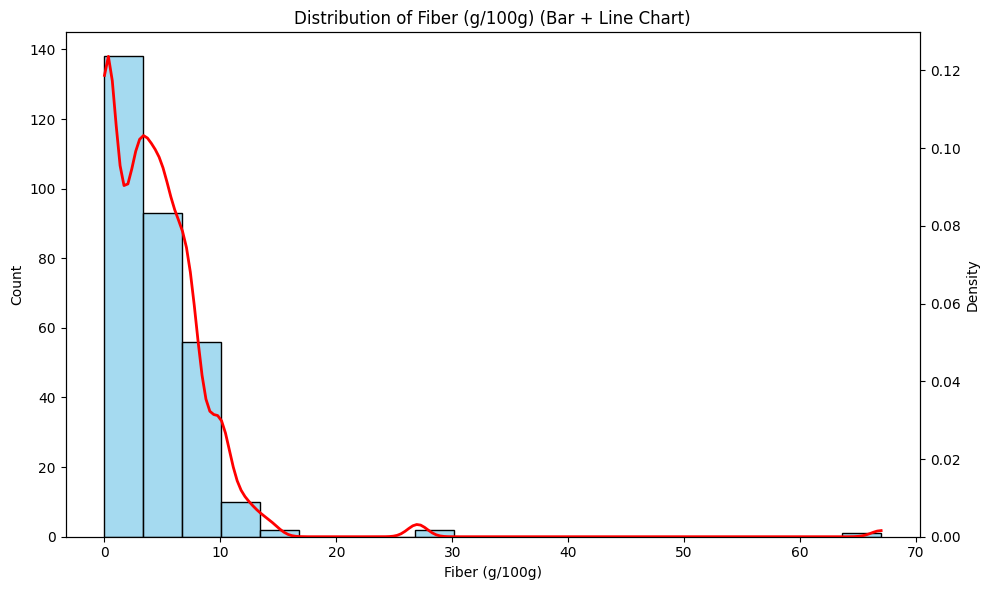

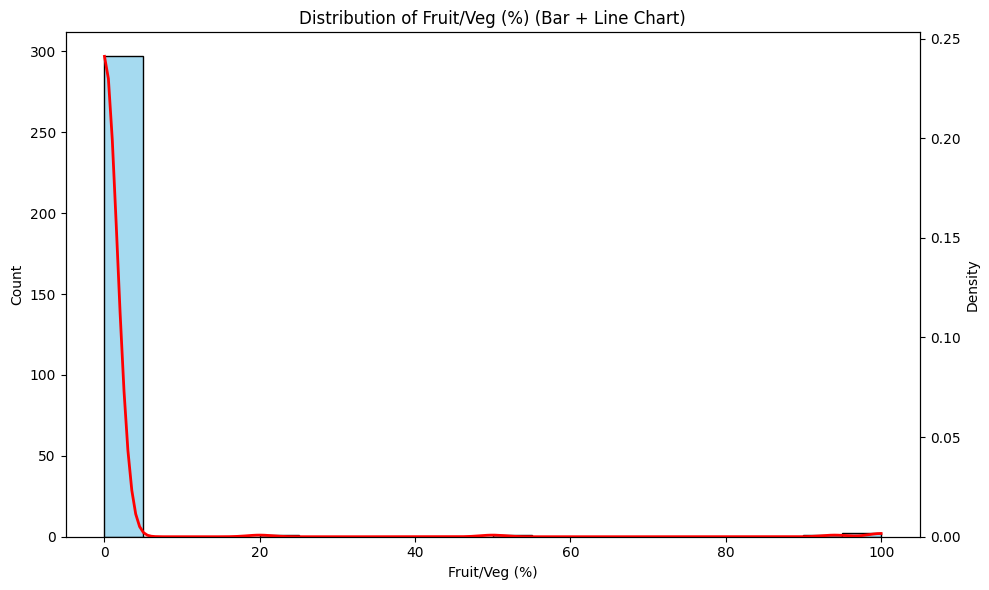

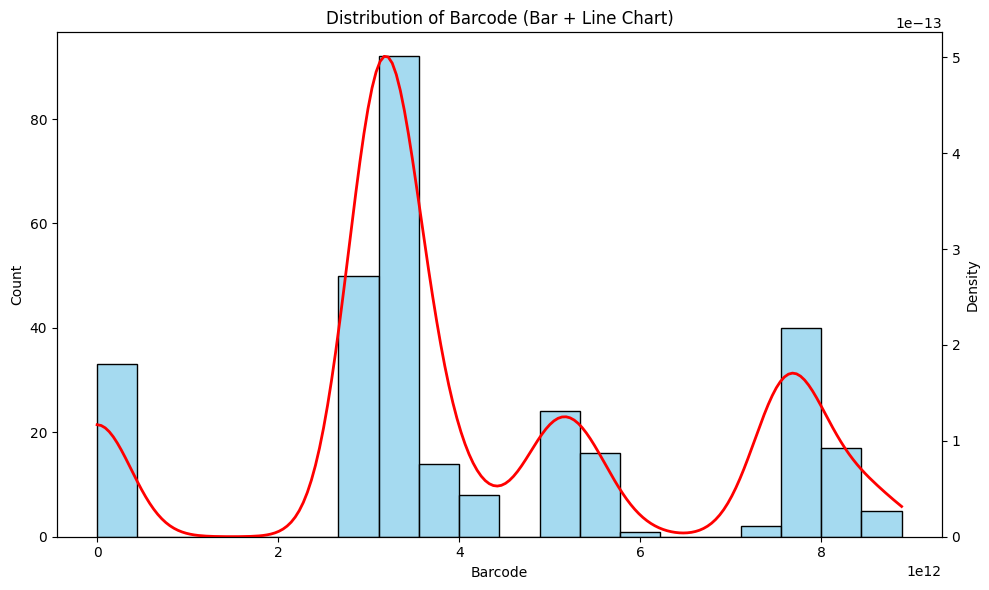

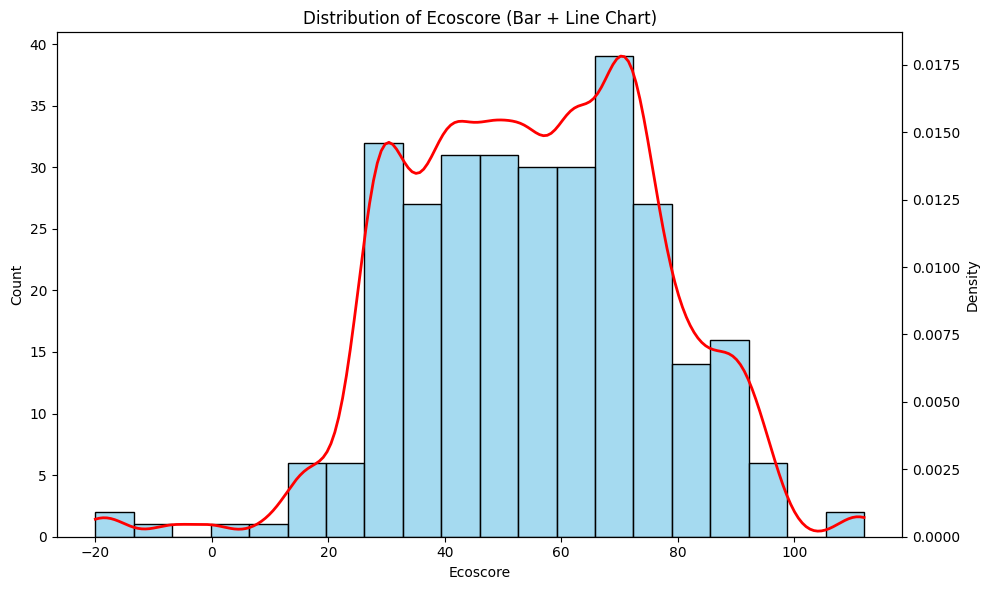

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot bar + line charts for numeric features
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    # Bar plot for frequencies
    sns.histplot(data[column], bins=20, color="skyblue", kde=False)

    # Add a line plot for density
    ax2 = plt.gca().twinx()
    sns.kdeplot(data[column], ax=ax2, color="red", linewidth=2, clip=(data[column].min(), data[column].max()), bw_adjust=0.5)

    plt.title(f"Distribution of {column} (Bar + Line Chart)")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    ax2.set_ylabel("Density")
    plt.tight_layout()
    plt.show()


<ipython-input-20-9daf62c6d54d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=nutri_counts.index, y=nutri_counts.values, palette="viridis")


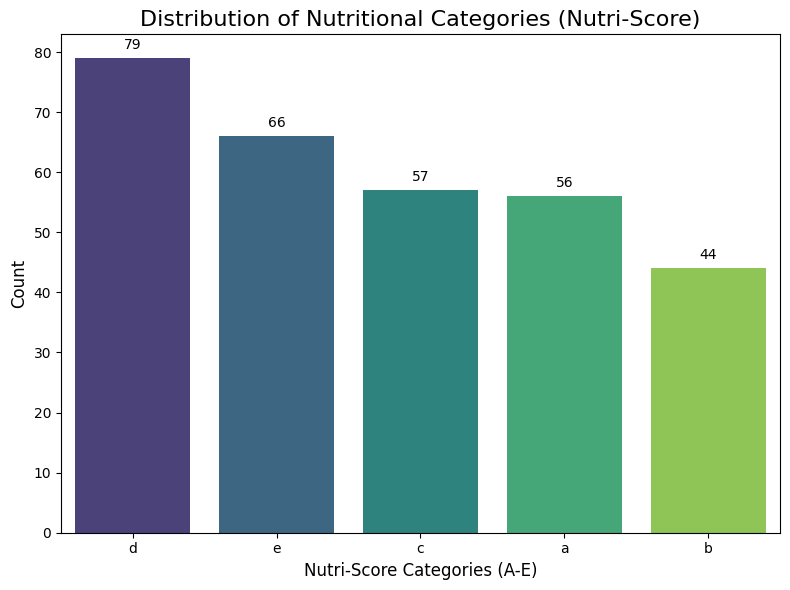

In [ ]:
# Load data if necessary (assuming 'data' is already loaded and contains 'Nutri-Score')

# Counting Nutri-Score categories
nutri_counts = data["Nutri-Score"].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=nutri_counts.index, y=nutri_counts.values, palette="viridis")

# Adding number labels on top of bars
for index, value in enumerate(nutri_counts.values):
    plt.text(index, value + 1.5, str(value), ha='center', fontsize=10)

# Adding titles and labels
plt.title("Distribution of Nutritional Categories (Nutri-Score)", fontsize=16)
plt.xlabel("Nutri-Score Categories (A-E)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


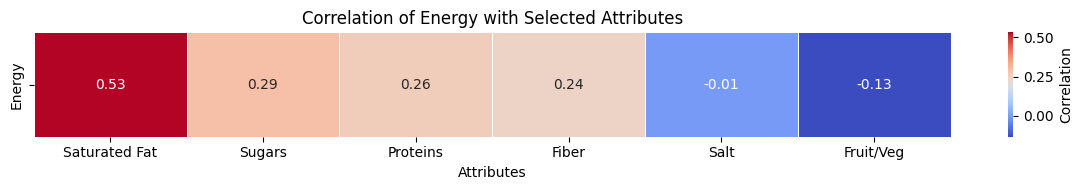

In [ ]:
#There is a correlation between some criteria since the following Equation (of the computation of Energy) shows that
#the criterion “Energy” depends on “Fat”, “Sugars”, “Proteins” and “Fibers”:
#Energy = (9×fat)+(7×alcohol)+(4×protein)+(4×sugar)+(2.4×organic acids)+(2.4×polyols)+(2×fibers) (5)


#Reorder attributes for the heatmap based on the given order
attributes_order = [
    "Saturated Fat",
    "Sugars",
    "Proteins",
    "Fiber",
    "Salt",
    "Fruit/Veg",
]

# Ensure these columns exist in the numeric_columns
attributes_to_plot = [attr for attr in attributes_order if attr in numeric_columns]

# Add remaining attributes not in the specified order
remaining_attributes = [col for col in numeric_columns if col not in attributes_order and col != "Energy"]
attributes_to_plot.extend(remaining_attributes)

# Filter and reorder the correlation matrix
energy_correlations = correlation_matrix.loc["Energy", attributes_to_plot]

# Plot the horizontal heatmap
plt.figure(figsize=(12, 2))
sns.heatmap(
    energy_correlations.to_frame().T,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={"label": "Correlation"},
    linewidths=0.5,
)
plt.title("Correlation of Energy with Selected Attributes")
plt.xlabel("Attributes")
plt.tight_layout()
plt.show()


In [ ]:
# Top 10 most frequent Food Names
if "Food Name" in data.columns:
    print("\nTop 10 Most Frequent Food Names:")
    print(data["Food Name"].value_counts().head(10))



Top 10 Most Frequent Food Names:
Food Name
Sésame                                1
Coco pops                             1
Lulu L'Ourson Chocolat                1
Galettes de riz bio                   1
Excellence 100% cacao noir infini     1
Bio napitak od zobi                   1
Chavroux Pur Chèvre                   1
Brioche tranchée nature ss additif    1
Roudor                                1
Biscuits Soja Figue                   1
Name: count, dtype: int64


<ipython-input-11-88e78aac18ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Nutri-Score", y=column, palette="Set3")


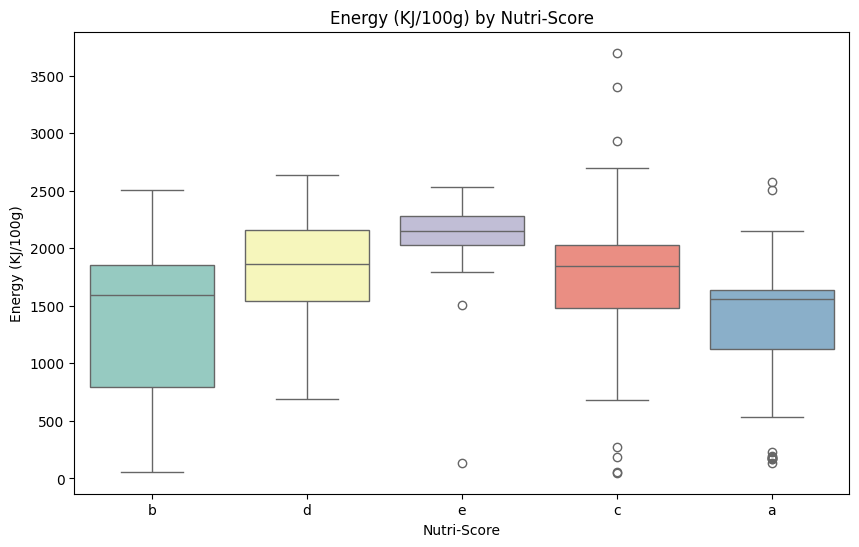

<ipython-input-11-88e78aac18ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Nutri-Score", y=column, palette="Set3")


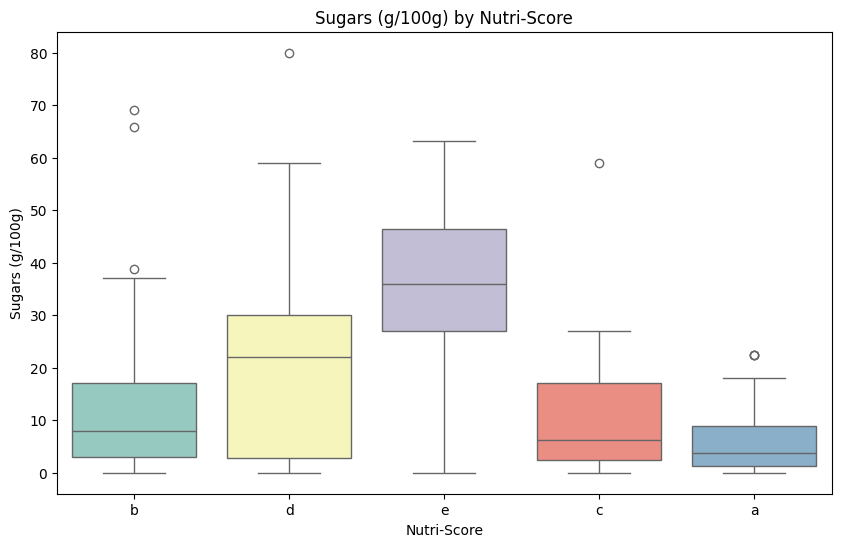

<ipython-input-11-88e78aac18ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Nutri-Score", y=column, palette="Set3")


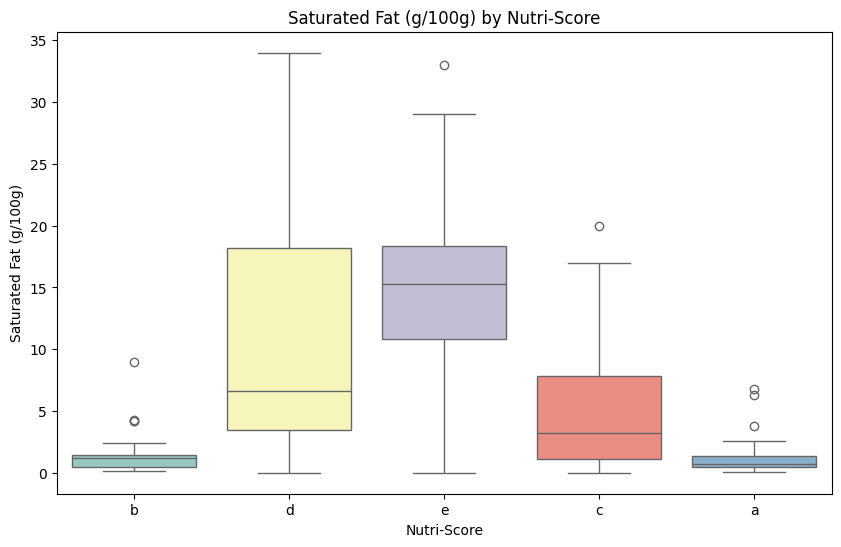

<ipython-input-11-88e78aac18ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Nutri-Score", y=column, palette="Set3")


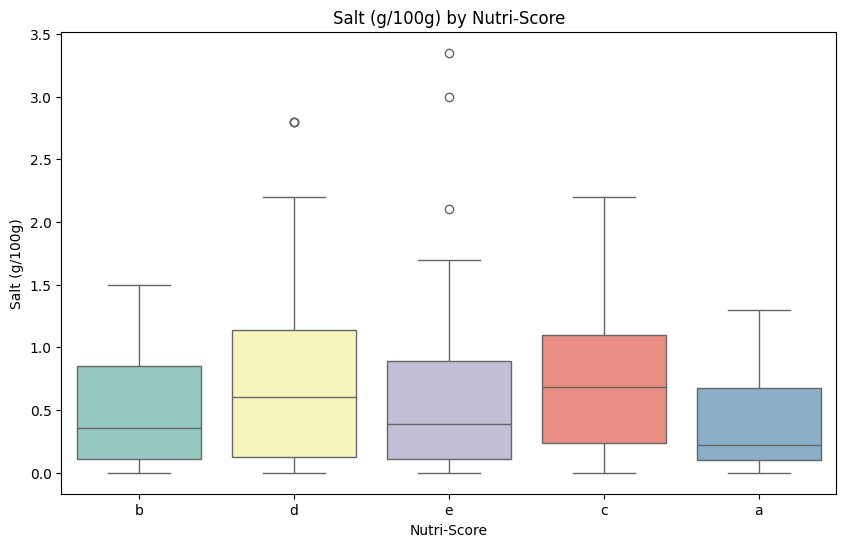

<ipython-input-11-88e78aac18ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Nutri-Score", y=column, palette="Set3")


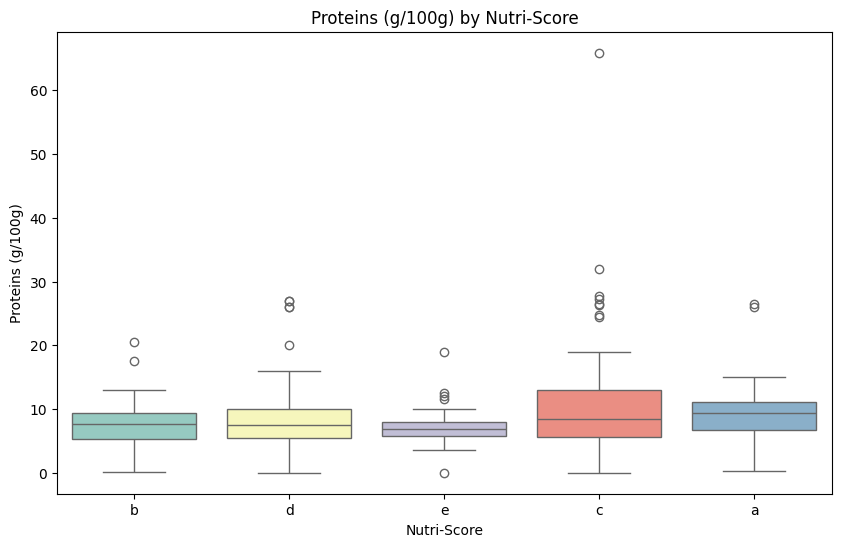

<ipython-input-11-88e78aac18ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Nutri-Score", y=column, palette="Set3")


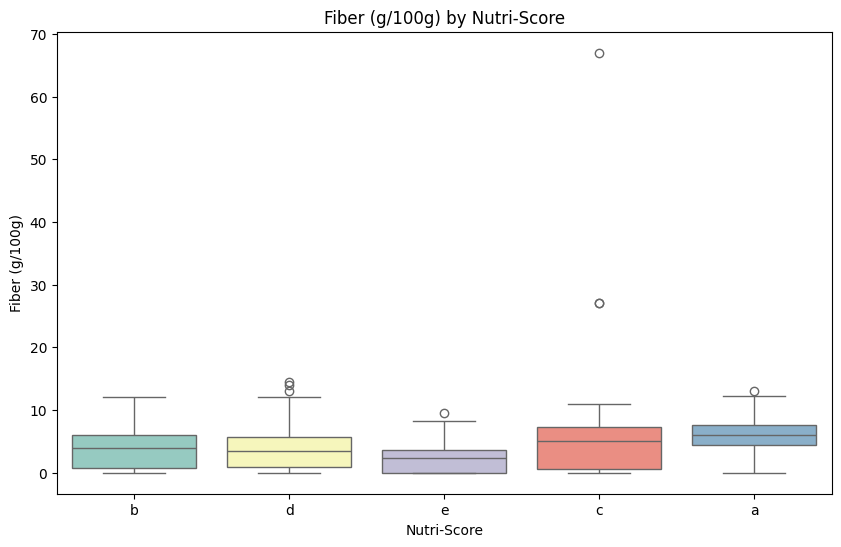

<ipython-input-11-88e78aac18ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Nutri-Score", y=column, palette="Set3")


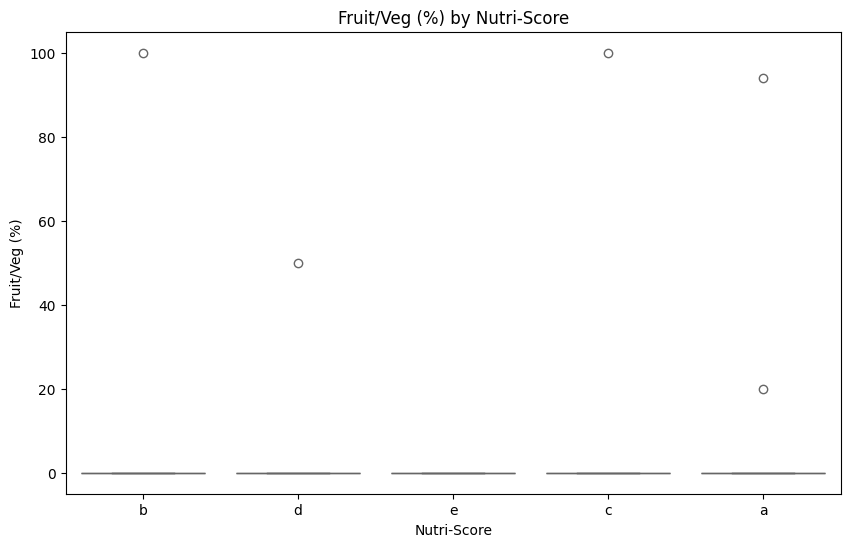

<ipython-input-11-88e78aac18ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Nutri-Score", y=column, palette="Set3")


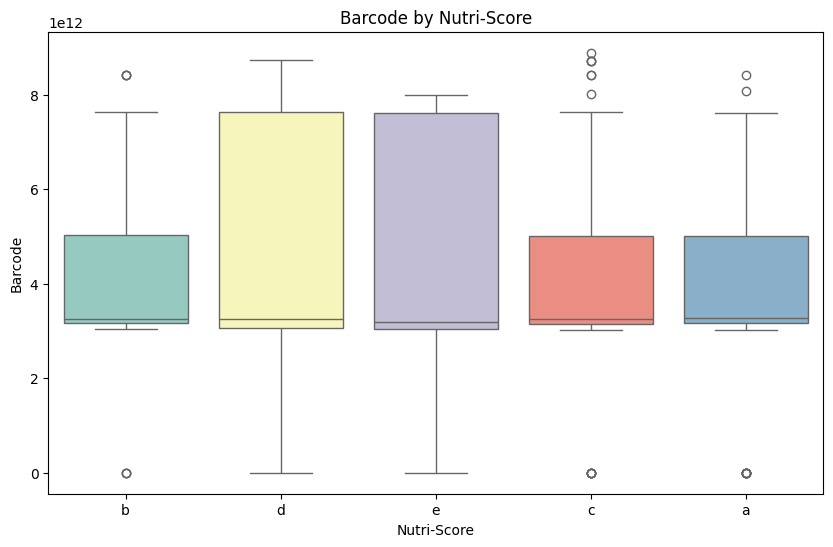

<ipython-input-11-88e78aac18ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Nutri-Score", y=column, palette="Set3")


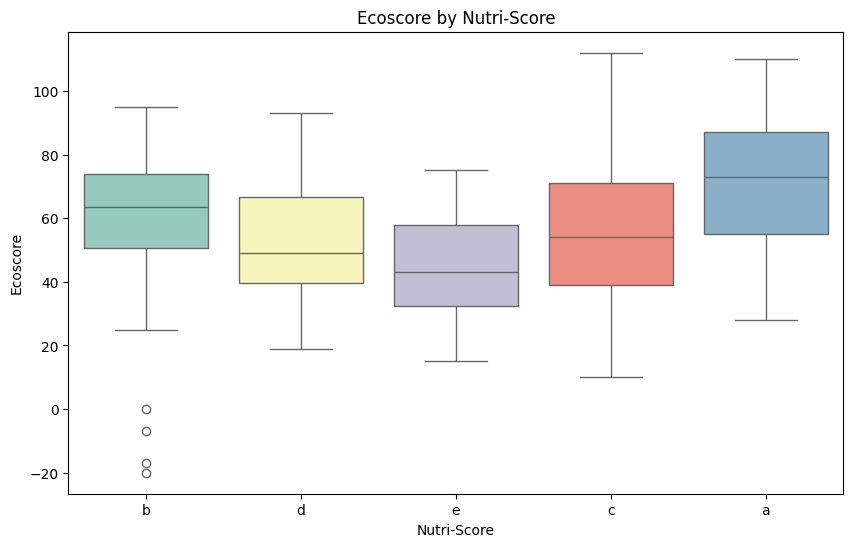

In [ ]:
# Boxplots for numeric features grouped by Nutri-Score
if "Nutri-Score" in data.columns:
    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=data, x="Nutri-Score", y=column, palette="Set3")
        plt.title(f"{column} by Nutri-Score")
        plt.xlabel("Nutri-Score")
        plt.ylabel(column)
        plt.show()


In [ ]:
# Check unique values for categorical columns
categorical_columns = data.select_dtypes(include=["object"]).columns
for column in categorical_columns:
    print(f"\nUnique values in {column}:")
    print(data[column].unique())



Unique values in Food Name:
['Sésame' 'Lindt Excellence 90% 100g'
 'Excellence 85% Cacao Chocolat Noir Puissant' 'Cashews' 'Tuc Original'
 'Pulco Zitrone' 'Geröstete Mandel Ohne Zucker'
 'Cracotte Céréales Complètes' 'Chocolat noir - 85% cacao'
 'Céréales Chocapic' 'Primevère' 'Oat Drink Barista Edition'
 'Tartines craquantes au sarrasin imp' 'Chocolat au lait du Pays Alpin'
 'Belvita Petit Déjeuner Chocolat' 'Biscottes 6 céréales'
 'Lu - Cracotte Original Wheat Slices, 250g (8.8oz)' 'Ohne Zucker Hafer'
 '14 Maxi Tranches complet sans sucres ajoutés' 'Figolu' 'Granola'
 'Tartine doux' 'Weetabix' 'Nestlé Dessert' 'Monaco' 'Muesli Superfruits'
 'Belvita Original Petit-Déjeuner miel et pépites de chocolat'
 'Biscuits goût chocolat' 'Pains au lait x10'
 'Pain de mie grandes tranches Seigle & Graines 500g'
 'Fourrés - Chocolat Noir' 'Doux 70% noir subtil' 'Biscuit soja orange'
 'Figue & son' 'Tartines craquantes quinoa - pois chiche'
 'Véritable Petit Beurre Pocket' 'Fresh Square 0% - Plai

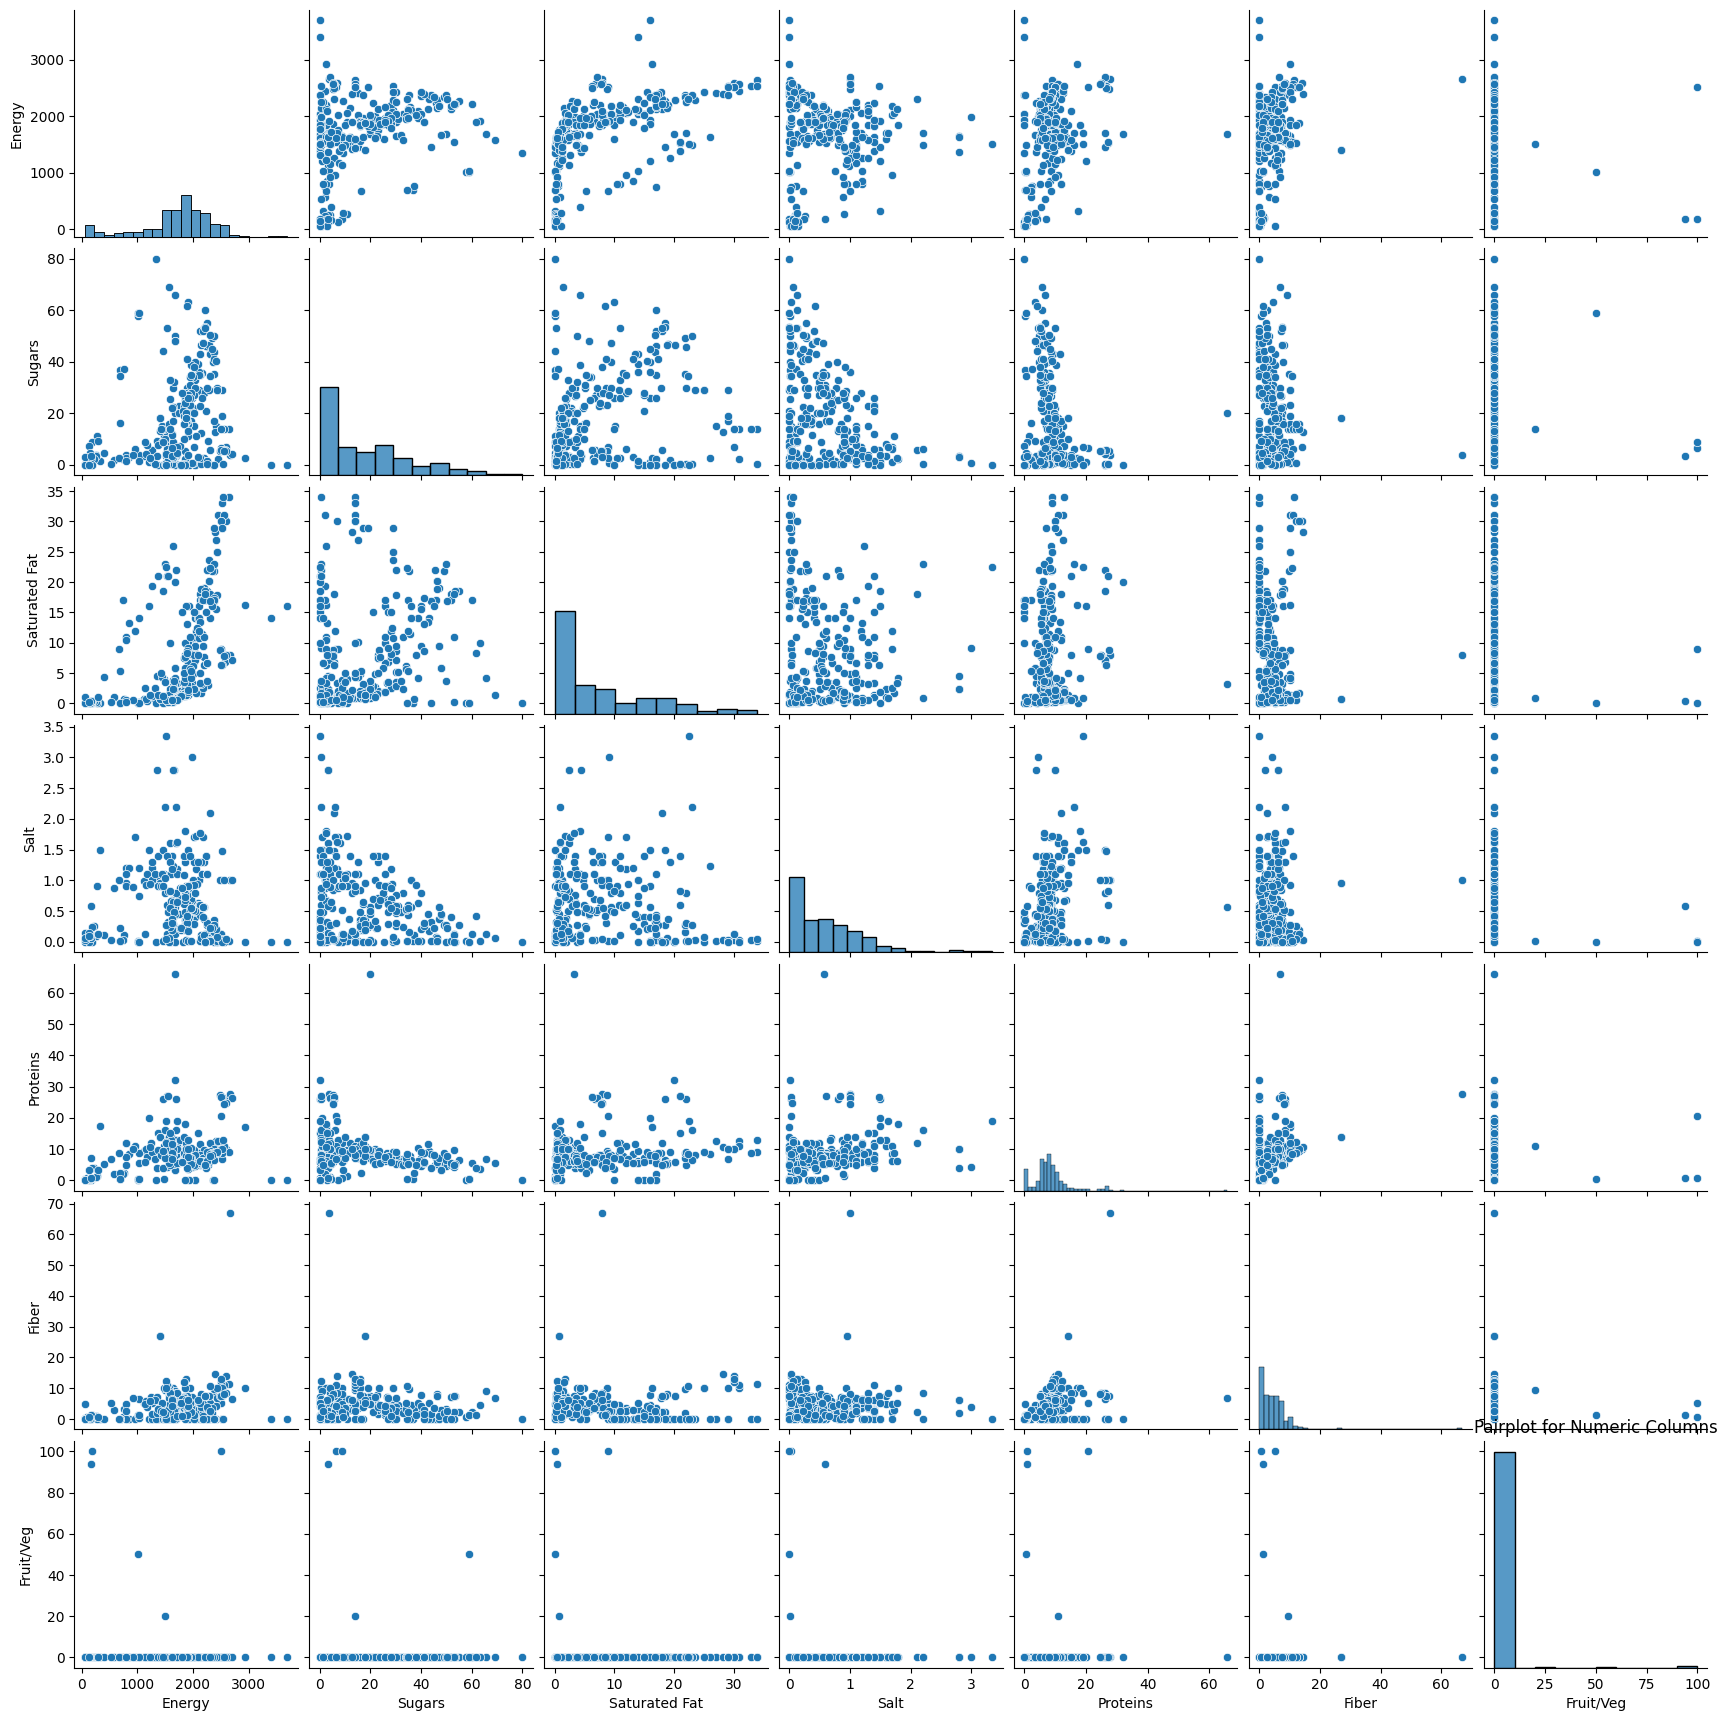

In [ ]:
# Pairplot for numeric columns
if len(numeric_columns) > 1:
    sns.pairplot(data[numeric_columns])
    plt.title("Pairplot for Numeric Columns")
    plt.show()


In [ ]:
# Example threshold generation function with printing
def generate_thresholds(data, columns):
    thresholds = {}
    for column in columns:
        quantiles = data[column].quantile([0.2, 0.4, 0.6, 0.8]).values
        thresholds[column] = [round(q, 2) for q in quantiles]
        # Print the thresholds for each column to verify
        print(f"Thresholds for {column}: {thresholds[column]}")
    return thresholds

# Assuming `columns_to_normalize` is already defined
thresholds = generate_thresholds(data, columns_to_normalize)


Thresholds for Energy (KJ/100g): [1402.6, 1670.8, 1905.6, 2190.0]
Thresholds for Sugars (g/100g): [2.5, 7.18, 18.6, 31.8]
Thresholds for Saturated Fat (g/100g): [0.8, 2.24, 6.76, 15.9]
Thresholds for Salt (g/100g): [0.06, 0.3, 0.65, 1.0]
Thresholds for Proteins (g/100g): [5.3, 7.1, 8.6, 11.0]
Thresholds for Fiber (g/100g): [0.5, 2.8, 4.8, 7.13]
Thresholds for Fruit/Veg (%): [0.0, 0.0, 0.0, 0.0]
